In [1]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file, output_notebook

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

In [2]:
conn = psycopg2.connect(host="localhost",database="mimic", user="postgres", password='postgres', port = '5432')
cursor = conn.cursor()

## Carevue fluid outliers -- high amounts.
We are including OR and PACU fluids in our fluid balance calculations.  These do lead to some outliers.  with  up to 33L charted.  see table below. 


In [51]:
# carevue Operating room charted fluids codes.  
sql = """select * 
from mimiciii.inputevents_cv
where itemid in ('30101', '30102') 
and amount is not null
order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head()

,row_id,subject_id,hadm_id,icustay_id,charttime,itemid,amount,amountuom,rate,rateuom,...,orderid,linkorderid,stopped,newbottle,originalamount,originalamountuom,originalroute,originalrate,originalrateuom,originalsite
0,937761,7413,134105.0,219750.0,2172-11-04 23:00:00,30101,33000.0,ml,None,None,...,3045093,3045093,None,NaN,NaN,ml,Intravenous Push,None,None,None
1,936251,11353,108739.0,286981.0,2113-05-30 13:00:00,30101,30000.0,ml,None,None,...,5785664,5785664,None,NaN,NaN,ml,Intravenous Push,None,None,None
2,904217,18463,128430.0,253611.0,2173-11-06 00:15:00,30101,22000.0,ml,None,None,...,9810761,9810761,None,NaN,NaN,ml,Intravenous Push,None,None,None
3,937637,19095,131302.0,210780.0,2143-11-12 18:00:00,30102,19836.0,ml,None,None,...,4010437,4010437,None,NaN,NaN,ml,Intravenous Push,None,None,None
4,946177,20854,120046.0,288220.0,2157-04-29 20:00:00,30102,19375.0,ml,None,None,...,10468351,10468351,None,1.0,NaN,ml,Intravenous Push,None,None,None


(array([  1.44160000e+04,   3.88900000e+03,   1.87000000e+03,
          7.38000000e+02,   2.77000000e+02,   7.90000000e+01,
          9.00000000e+01,   3.80000000e+01,   1.90000000e+01,
          1.60000000e+01,   3.00000000e+00,   3.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00]),
 array([     0.,   1650.,   3300.,   4950.,   6600.,   8250.,   9900.,
         11550.,  13200.,  14850.,  16500.,  18150.,  19800.,  21450.,
         23100.,  24750.,  26400.,  28050.,  29700.,  31350.,  33000.]),
 <a list of 20 Patch objects>)

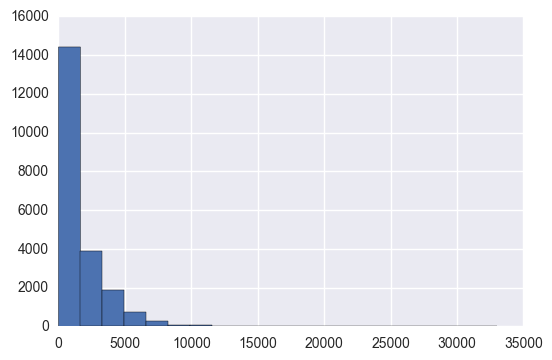

In [52]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
plt.hist(plot_data, bins=20)

In [53]:
output_notebook()
p = figure(
   tools="pan,box_zoom,reset,save",
   title="Carevue OR fluid amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p)

Loading BokehJS ...

In [54]:
# top Carevision input amounts:
sql = """
select * 
from fluid_cv_itemtotal
order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head(100)

,icustay_id,day_since_admission,itemid,label,amount
0,219750,0.0,30101,OR Crystalloid,33000.0
1,245712,0.0,30030,Sodium Bicarbonate,30300.0
2,202865,48.0,30168,Normal Saline_GU,30000.0
3,286981,0.0,30101,OR Crystalloid,30000.0
4,253611,0.0,30101,OR Crystalloid,22000.0
5,210780,0.0,30102,OR Colloid,19836.0
6,288220,0.0,30102,OR Colloid,19375.0
7,223601,0.0,30101,OR Crystalloid,19000.0
8,245712,0.0,30030,Sodium Bicarbonate,18937.5
9,221955,0.0,30101,OR Crystalloid,18670.0


In [55]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p2 = figure(
   tools="pan,box_zoom,reset,save",
   title="Carevue fluid single item amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p2)

Loading BokehJS ...

## OR and PACU fluids do not end up in final extract from Metavision because they are listed as preadmission

In [56]:
## OR, PACU fluid from Metavision. empty results, so OR fluids not contributing to high fluid volumes.

sql = """SELECT row_id, subject_id, hadm_id, icustay_id, starttime, endtime, 
       itemid, amount, amountuom, rate, rateuom, storetime, patientweight, totalamount, totalamountuom, 
       isopenbag, continueinnextdept, cancelreason, statusdescription, 
       comments_editedby, comments_canceledby, comments_date,originalamount, 
       originalrate
  FROM mimiciii.inputevents_mv
  where itemid in ('226364', '226375', '226365', '226367')
  and amount > 0  -- amount can be negative, often for REWRITTEN orders.  
		and cancelreason = 0 -- some orders are cancelled
		and statusdescription != 'Rewritten'  -- not sure if this should be a filter.
		and ordercategoryname not like '%Pre Admission%' -- Pre Admission fluid can be very high and cover uncertain amount of time.  
		and icustay_id is not null
  order by amount desc
"""
df = pd.read_sql_query(sql, conn)
df.head()

,row_id,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,amount,amountuom,rate,...,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_editedby,comments_canceledby,comments_date,originalamount,originalrate


## Metavision, top amounts of fluid 
top fluid up to 30L, come from LR PRBC, etc.  some of these are not yet in updated fluid extractions.  

In [57]:
sql = """SELECT f.row_id, f.subject_id, f.icustay_id, f.hadm_id, f.itemid, d.label, f.rate, f.amount, 
       starttime, endtime
  FROM mimiciii.fluid_mv_itemtotal as f
  join d_items as d
  on f.itemid = d.itemid
order by amount desc"""
df = pd.read_sql_query(sql, conn)


In [58]:
# top metavision input amounts
df.head(100)

,row_id,subject_id,icustay_id,hadm_id,itemid,label,rate,amount,starttime,endtime
0,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-10 00:00:00,2153-10-11 00:00:00
1,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-06 00:00:00,2153-10-07 00:00:00
2,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-04 23:35:00,2153-10-05 00:00:00
3,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-07 00:00:00,2153-10-08 00:00:00
4,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-08 00:00:00,2153-10-09 00:00:00
5,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-11 00:00:00,2153-10-11 05:25:00
6,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-09 00:00:00,2153-10-10 00:00:00
7,228655,73579,299144,159680,225828,LR,200.222466,29999.999489,2153-10-05 00:00:00,2153-10-06 00:00:00
8,711219,64590,253402,160850,225168,Packed Red Blood Cells,14250.000000,14250.000000,2123-04-06 03:27:00,2123-04-06 04:27:00
9,711213,64590,253402,160850,220970,Fresh Frozen Plasma,13800.000000,13800.000000,2123-04-06 03:31:00,2123-04-06 04:31:00


In [60]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p1 = figure(
   tools="pan,box_zoom,reset,save",
   title="Metavision fluid single item amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p1)

Loading BokehJS ...

## Distribution of Output fluid amounts.  What is contributing to high fluid amounts. 
high output charting are from OR, PACU EBL

In [67]:
sql = """SELECT f.* , d.label
  FROM mimiciii.output_itemtotal as f
  join d_items as d
  on f.itemid = d.itemid
order by amount desc"""
df = pd.read_sql_query(sql, conn)
df.head()

,icustay_id,intime,charttime,elapsed,itemid,amount,day_since_admission,label
0,211323,2186-02-26 20:34:07,2186-03-02 17:09:00,3 days 20:34:53,226626,50500.0,3.0,OR EBL
1,247086,2180-08-23 03:30:27,2180-08-23 12:41:00,0 days 09:10:33,226626,50000.0,0.0,OR EBL
2,234698,2122-04-29 20:33:01,2122-04-29 23:45:00,0 days 03:11:59,226626,50000.0,0.0,OR EBL
3,245211,2113-03-29 16:16:11,2113-03-30 13:00:00,0 days 20:43:49,226559,47050.0,0.0,Foley
4,272472,2122-01-02 11:18:40,2122-01-11 21:16:00,9 days 09:57:20,226626,30000.0,9.0,OR EBL


In [70]:
# top output amounts: 
df.head(100)

,icustay_id,intime,charttime,elapsed,itemid,amount,day_since_admission,label
0,211323,2186-02-26 20:34:07,2186-03-02 17:09:00,3 days 20:34:53,226626,50500.0,3.0,OR EBL
1,247086,2180-08-23 03:30:27,2180-08-23 12:41:00,0 days 09:10:33,226626,50000.0,0.0,OR EBL
2,234698,2122-04-29 20:33:01,2122-04-29 23:45:00,0 days 03:11:59,226626,50000.0,0.0,OR EBL
3,245211,2113-03-29 16:16:11,2113-03-30 13:00:00,0 days 20:43:49,226559,47050.0,0.0,Foley
4,272472,2122-01-02 11:18:40,2122-01-11 21:16:00,9 days 09:57:20,226626,30000.0,9.0,OR EBL
5,266780,2185-02-21 19:38:00,2185-02-21 22:00:00,0 days 02:22:00,40064,30000.0,0.0,OR Out EBL
6,279359,2152-01-13 00:18:16,2152-01-15 22:51:00,2 days 22:32:44,226626,30000.0,2.0,OR EBL
7,228565,2148-12-07 12:30:16,2148-12-10 20:45:00,3 days 08:14:44,226629,29000.0,3.0,PACU EBL
8,221684,2119-10-30 15:42:34,2119-11-11 06:00:00,11 days 14:17:26,227489,28000.0,11.0,GU Irrigant/Urine Volume Out
9,233025,2178-12-14 10:45:00,2178-12-15 08:00:00,0 days 21:15:00,40584,28000.0,0.0,PD out


In [69]:
plot_data = df.amount
plot_data = plot_data[~np.isnan(plot_data)]
output_notebook()
p2 = figure(
   tools="pan,box_zoom,reset,save",
   title="Output fluid single item amounts",
   x_axis_label='amount (ml)', y_axis_label='rows charted'
)
hist, edges = np.histogram(plot_data, bins=50)
p2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
        fill_color="#036564", line_color="#033649")
show(p2)

Loading BokehJS ...

## are there any days without output measured?? --> yes. but only for minority of cases, and mostly not during first 3 days of ICU admission.  

In [76]:
sql = """with cte as 
(SELECT *, row_number() over (partition by icustay_id order by day_since_admission) as rn 
  FROM mimiciii.output_dailytotal)


, diff as (select a.*, b.day_since_admission - a.day_since_admission as d
  from cte a
  left join cte b
    on a.icustay_id = b. icustay_id
    and a.rn = b.rn-1)

select * from diff
where d is not null and d > 1
order by d desc
"""
df = pd.read_sql_query(sql, conn)
df

,icustay_id,day_since_admission,dailytotal_ml,rn,d
0,253919,12.0,0.00,13,96.0
1,223304,28.0,0.00,21,92.0
2,246145,29.0,0.00,23,91.0
3,235684,47.0,0.00,41,91.0
4,261571,29.0,0.00,20,90.0
5,229485,25.0,0.00,24,84.0
6,232928,8.0,29.00,9,72.0
7,214819,8.0,17.00,9,72.0
8,233789,52.0,36.00,45,63.0
9,245519,14.0,0.00,15,62.0


Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq\backend\cython\message.c:4018)
    PyErr_CheckSignals()
KeyboardInterrupt


(array([ 898.,  374.,  254.,  269.,  169.,  136.,  126.,  139.,   76.,
          79.,   81.,   49.,   36.,   44.,   40.,   29.,   24.,   19.,
          15.,   16.,    6.,    6.,    3.,    8.,    6.,    6.,    5.,
           7.,   12.,    2.,    4.,    3.,    5.,    3.,    3.,    1.,
           1.,    2.,    1.,    1.,    1.,    1.,    0.,    0.,    0.,
           1.,    0.,    1.,    0.,    1.]),
 array([   0.  ,    3.28,    6.56,    9.84,   13.12,   16.4 ,   19.68,
          22.96,   26.24,   29.52,   32.8 ,   36.08,   39.36,   42.64,
          45.92,   49.2 ,   52.48,   55.76,   59.04,   62.32,   65.6 ,
          68.88,   72.16,   75.44,   78.72,   82.  ,   85.28,   88.56,
          91.84,   95.12,   98.4 ,  101.68,  104.96,  108.24,  111.52,
         114.8 ,  118.08,  121.36,  124.64,  127.92,  131.2 ,  134.48,
         137.76,  141.04,  144.32,  147.6 ,  150.88,  154.16,  157.44,
         160.72,  164.  ]),
 <a list of 50 Patch objects>)

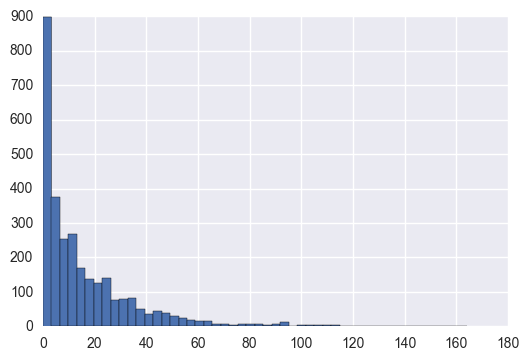

In [81]:
# day after which no output is charted.
plt.hist(df.day_since_admission, bins=50)

In [84]:
df[df.day_since_admission < 3].count()

icustay_id             719
day_since_admission    719
dailytotal_ml          719
rn                     719
d                      719
dtype: int64

In [85]:
df[df.day_since_admission > 3].count()

icustay_id             2065
day_since_admission    2065
dailytotal_ml          2065
rn                     2065
d                      2065
dtype: int64

In [86]:
719/2065

0.34818401937046006

#  2/28/2017 -- how to balance input & output filters so we do not end up with large implausible fluid balances?

In [103]:
sql = """SELECT icustay_id, day_since_admission, daily_input_ml, daily_output_ml, 
       daily_balance_ml, cumulative_balance_ml, abs(daily_balance_ml) as abs_daily_balnace_ml
  FROM mimiciii.fluid_dailybalance
  where day_since_admission < 4 and abs(daily_balance_ml) > 20000
  order by abs(daily_balance_ml) desc
  --limit 100;
  """
df = pd.read_sql_query(sql, conn)
df.head()


,icustay_id,day_since_admission,daily_input_ml,daily_output_ml,daily_balance_ml,cumulative_balance_ml,abs_daily_balnace_ml
0,290677,2.0,1200.000160,307160.0,-305959.999840,-529245.083108,305959.999840
1,290677,3.0,1117.083347,285700.0,-284582.916653,-813827.999760,284582.916653
2,258971,0.0,1964.999921,164465.0,-162500.000079,-162500.000079,162500.000079
3,289956,2.0,3304.117328,161612.0,-158307.882672,-331965.792185,158307.882672
4,290677,1.0,1059.750063,154180.0,-153120.249937,-223285.083268,153120.249937


(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   1.,   0.,   1.,
          1.,   3.,   2.,   2.,   1.,   2.,   2.,   0.,   6.,   6.,   7.,
          8.,  19.,  19.,  20.,   0.,   0.,   0.,   0.,  16.,  10.,   1.,
          0.,   1.,   0.,   0.,   1.,   1.]),
 array([-305959.99983993, -298131.74984313, -290303.49984633,
        -282475.24984954, -274646.99985274, -266818.74985594,
        -258990.49985914, -251162.24986234, -243333.99986554,
        -235505.74986874, -227677.49987194, -219849.24987515,
        -212020.99987835, -204192.74988155, -196364.49988475,
        -188536.24988795, -180707.99989115, -172879.74989435,
        -165051.49989756, -157223.24990076, -149394.99990396,
        -141566.74990716, -133738.49991036, -125910.24991356,
        -118081.99991676, -110253.74991997, -102425.49992317,
         -94597.24992637,  -86768.99992957,  -78940.74993277,
         -71112.49993597,  -63284.2499

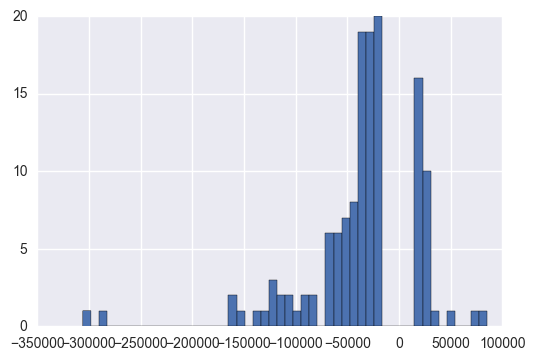

In [104]:
plt.hist(df.daily_balance_ml, bins=50)

# decided to do the following:
#1. exclude GU Irrigant/Urine Volume Out as these are causing large fluid out values> 8L.
#2. exclude GU Irrigant Volume in ... why are these in output table?  

In [105]:
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where icustay_id = '290677'
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
df.head(100)

,icustay_id,intime,charttime,elapsed,itemid,amount,day_since_admission,label
0,290677,2171-04-16 23:45:44,2171-04-21 02:00:00,4 days 02:14:16,227489,12950.0,4.0,GU Irrigant/Urine Volume Out
1,290677,2171-04-16 23:45:44,2171-04-22 01:00:00,5 days 01:14:16,227489,12600.0,5.0,GU Irrigant/Urine Volume Out
2,290677,2171-04-16 23:45:44,2171-04-22 01:00:00,5 days 01:14:16,227488,12000.0,5.0,GU Irrigant Volume In
3,290677,2171-04-16 23:45:44,2171-04-21 05:00:00,4 days 05:14:16,227489,9900.0,4.0,GU Irrigant/Urine Volume Out
4,290677,2171-04-16 23:45:44,2171-04-21 00:00:00,4 days 00:14:16,227489,9700.0,4.0,GU Irrigant/Urine Volume Out
5,290677,2171-04-16 23:45:44,2171-04-21 01:00:00,4 days 01:14:16,227489,9600.0,4.0,GU Irrigant/Urine Volume Out
6,290677,2171-04-16 23:45:44,2171-04-21 04:00:00,4 days 04:14:16,227489,9500.0,4.0,GU Irrigant/Urine Volume Out
7,290677,2171-04-16 23:45:44,2171-04-21 06:00:00,4 days 06:14:16,227489,9500.0,4.0,GU Irrigant/Urine Volume Out
8,290677,2171-04-16 23:45:44,2171-04-20 01:00:00,3 days 01:14:16,227489,9450.0,3.0,GU Irrigant/Urine Volume Out
9,290677,2171-04-16 23:45:44,2171-04-19 13:00:00,2 days 13:14:16,227489,9400.0,2.0,GU Irrigant/Urine Volume Out


In [3]:
## distributions of high output items
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '40584' --PD out
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
df.head(100)

,icustay_id,intime,charttime,elapsed,itemid,amount,day_since_admission,label
0,233025,2178-12-14 10:45:00,2178-12-15 08:00:00,0 days 21:15:00,40584,28000.0,0.0,PD out
1,233025,2178-12-14 10:45:00,2178-12-15 12:00:00,1 days 01:15:00,40584,27000.0,1.0,PD out
2,233025,2178-12-14 10:45:00,2178-12-15 16:00:00,1 days 05:15:00,40584,27000.0,1.0,PD out
3,233025,2178-12-14 10:45:00,2178-12-15 10:00:00,0 days 23:15:00,40584,27000.0,0.0,PD out
4,284715,2187-12-14 04:08:01,2187-12-14 22:00:00,0 days 17:51:59,40584,2500.0,0.0,PD out
5,284715,2187-12-14 04:08:01,2187-12-15 08:00:00,1 days 03:51:59,40584,2300.0,1.0,PD out
6,284715,2187-12-14 04:08:01,2187-12-15 12:30:00,1 days 08:21:59,40584,2300.0,1.0,PD out
7,284715,2187-12-14 04:08:01,2187-12-15 02:00:00,0 days 21:51:59,40584,2250.0,0.0,PD out
8,284715,2187-12-14 04:08:01,2187-12-15 17:00:00,1 days 12:51:59,40584,2200.0,1.0,PD out
9,284715,2187-12-14 04:08:01,2187-12-14 16:00:00,0 days 11:51:59,40584,1600.0,0.0,PD out


(array([ 8.,  0.,  1.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.]),
 array([     0.,    560.,   1120.,   1680.,   2240.,   2800.,   3360.,
          3920.,   4480.,   5040.,   5600.,   6160.,   6720.,   7280.,
          7840.,   8400.,   8960.,   9520.,  10080.,  10640.,  11200.,
         11760.,  12320.,  12880.,  13440.,  14000.,  14560.,  15120.,
         15680.,  16240.,  16800.,  17360.,  17920.,  18480.,  19040.,
         19600.,  20160.,  20720.,  21280.,  21840.,  22400.,  22960.,
         23520.,  24080.,  24640.,  25200.,  25760.,  26320.,  26880.,
         27440.,  28000.]),
 <a list of 50 Patch objects>)

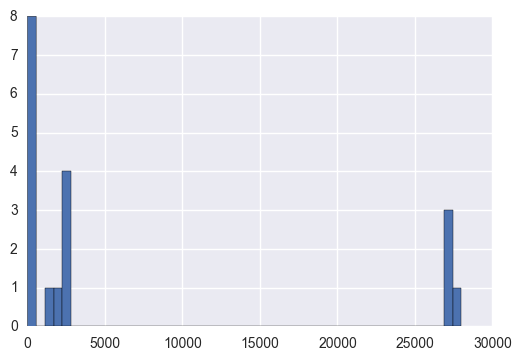

In [4]:
plt.hist(df.amount, bins=50)

(array([  1.18433900e+06,   1.81200000e+03,   1.00000000e+02,
          1.40000000e+01,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

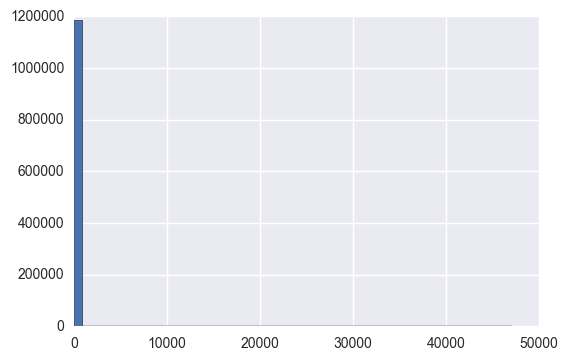

In [5]:
## distributions of high output items
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '226559' --Foley
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.amount, bins=50)

(array([ 43.,   4.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([     0.,    580.,   1160.,   1740.,   2320.,   2900.,   3480.,
          4060.,   4640.,   5220.,   5800.,   6380.,   6960.,   7540.,
          8120.,   8700.,   9280.,   9860.,  10440.,  11020.,  11600.,
         12180.,  12760.,  13340.,  13920.,  14500.,  15080.,  15660.,
         16240.,  16820.,  17400.,  17980.,  18560.,  19140.,  19720.,
         20300.,  20880.,  21460.,  22040.,  22620.,  23200.,  23780.,
         24360.,  24940.,  25520.,  26100.,  26680.,  27260.,  27840.,
         28420.,  29000.]),
 <a list of 50 Patch objects>)

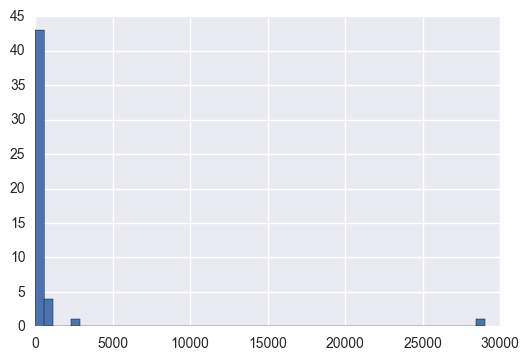

In [6]:
## distributions of high output items
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '226629' --PACU EBL
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.amount, bins=50)

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([     0. ,    271.4,    542.8,    814.2,   1085.6,   1357. ,
          1628.4,   1899.8,   2171.2,   2442.6,   2714. ,   2985.4,
          3256.8,   3528.2,   3799.6,   4071. ,   4342.4,   4613.8,
          4885.2,   5156.6,   5428. ,   5699.4,   5970.8,   6242.2,
          6513.6,   6785. ,   7056.4,   7327.8,   7599.2,   7870.6,
          8142. ,   8413.4,   8684.8,   8956.2,   9227.6,   9499. ,
          9770.4,  10041.8,  10313.2,  10584.6,  10856. ,  11127.4,
         11398.8,  11670.2,  11941.6,  12213. ,  12484.4,  12755.8,
         13027.2,  13298.6,  13570. ]),
 <a list of 50 Patch objects>)

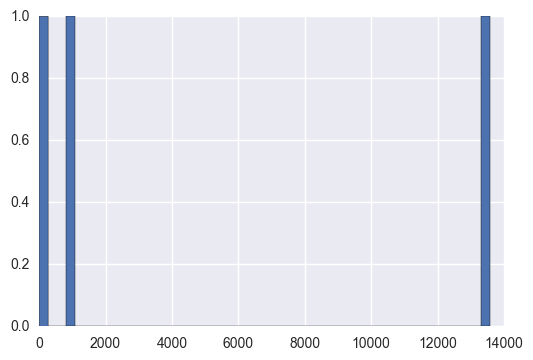

In [8]:
## distributions of high output items
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '43804' --outside hsp
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.amount, bins=50)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 11999.5 ,  11999.52,  11999.54,  11999.56,  11999.58,  11999.6 ,
         11999.62,  11999.64,  11999.66,  11999.68,  11999.7 ,  11999.72,
         11999.74,  11999.76,  11999.78,  11999.8 ,  11999.82,  11999.84,
         11999.86,  11999.88,  11999.9 ,  11999.92,  11999.94,  11999.96,
         11999.98,  12000.  ,  12000.02,  12000.04,  12000.06,  12000.08,
         12000.1 ,  12000.12,  12000.14,  12000.16,  12000.18,  12000.2 ,
         12000.22,  12000.24,  12000.26,  12000.28,  12000.3 ,  12000.32,
         12000.34,  12000.36,  12000.38,  12000.4 ,  12000.42,  12000.44,
         12000.46,  12000.48,  12000.5 ]),
 <a list of 50 Patch objects>)

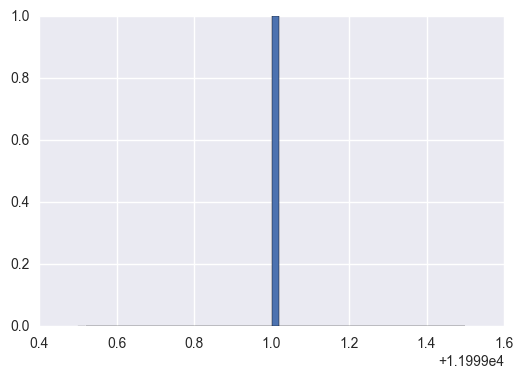

In [9]:
## distributions of high output items
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '46645' --ascities out
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.amount, bins=50)

(array([ 110.,  106.,   82.,   48.,   20.,   31.,   10.,   23.,    4.,
          21.,    3.,   11.,    9.,    1.,    2.,    2.,    2.,    2.,
           2.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    1.]),
 array([     0.,    540.,   1080.,   1620.,   2160.,   2700.,   3240.,
          3780.,   4320.,   4860.,   5400.,   5940.,   6480.,   7020.,
          7560.,   8100.,   8640.,   9180.,   9720.,  10260.,  10800.,
         11340.,  11880.,  12420.,  12960.,  13500.,  14040.,  14580.,
         15120.,  15660.,  16200.,  16740.,  17280.,  17820.,  18360.,
         18900.,  19440.,  19980.,  20520.,  21060.,  21600.,  22140.,
         22680.,  23220.,  23760.,  24300.,  24840.,  25380.,  25920.,
         26460.,  27000.]),
 <a list of 50 Patch objects>)

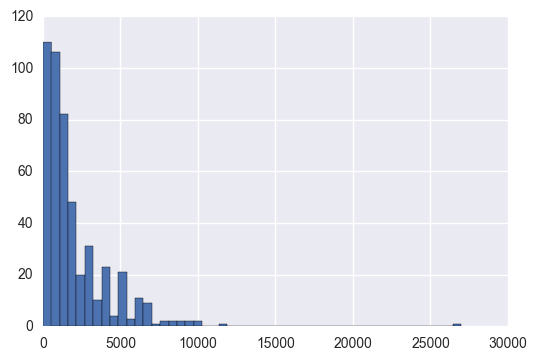

In [10]:
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '226625' --Tap
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.amount, bins=50)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
         0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
         0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 50 Patch objects>)

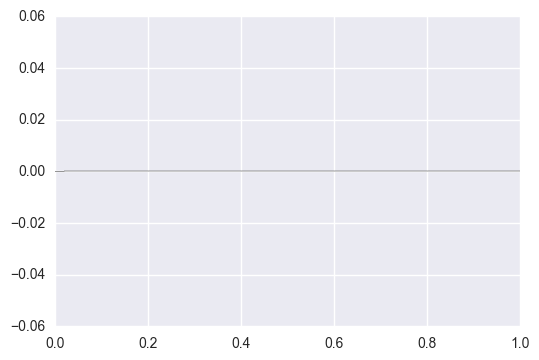

In [11]:
sql = """SELECT t.*, d.label
  FROM mimiciii.output_itemtotal as t
  join d_items as d
  on t.itemid = d.itemid
    where d.itemid= '40065' --OR Out PACU Urine
  order by amount desc;"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.amount, bins=50)

## truncated fluid balance

(array([   329.,     55.,     76.,     94.,    135.,    213.,    254.,
           404.,    493.,    738.,    963.,   1374.,   1869.,   2581.,
          3347.,   4471.,   5706.,   7140.,   8729.,  10500.,  12220.,
         13782.,  14575.,  14957.,  19436.,  14025.,   9579.,   7392.,
          5896.,   4600.,   3777.,   3155.,   2546.,   2101.,   1712.,
          1401.,   1155.,   1030.,    816.,    724.,    577.,    497.,
           401.,    342.,    312.,    283.,    228.,    188.,    194.,
          1439.]),
 array([-8000., -7680., -7360., -7040., -6720., -6400., -6080., -5760.,
        -5440., -5120., -4800., -4480., -4160., -3840., -3520., -3200.,
        -2880., -2560., -2240., -1920., -1600., -1280.,  -960.,  -640.,
         -320.,     0.,   320.,   640.,   960.,  1280.,  1600.,  1920.,
         2240.,  2560.,  2880.,  3200.,  3520.,  3840.,  4160.,  4480.,
         4800.,  5120.,  5440.,  5760.,  6080.,  6400.,  6720.,  7040.,
         7360.,  7680.,  8000.]),
 <a list of 50 Pat

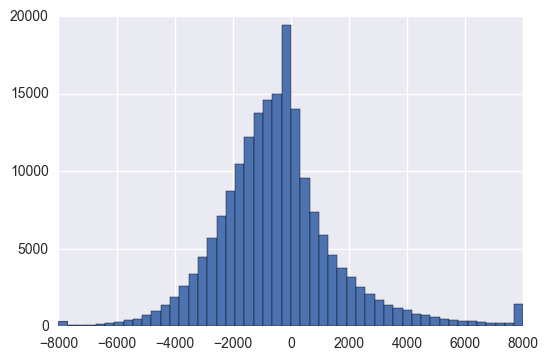

In [3]:
sql = """SELECT *
  FROM mimiciii.fluid_dailybalance"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.daily_balance_ml, bins=50)

(array([  2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   5.00000000e+00,
          6.00000000e+00,   4.00000000e+00,   1.20000000e+01,
          1.30000000e+01,   2.10000000e+01,   2.50000000e+01,
          4.50000000e+01,   1.58000000e+02,   1.21230000e+04,
          1.50465000e+05,   2.31830000e+04,   2.16300000e+03,
          3.84000000e+02,   1.23000000e+02,   3.90000000e+01,
          1.10000000e+01,   8.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
        

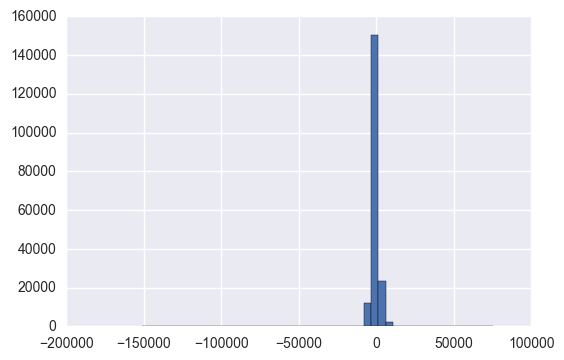

In [5]:
plt.hist(df.daily_balance_ml_pretruncate, bins=50)

(array([ 33922.,   1008.,   1086.,   1199.,   1231.,   1328.,   1369.,
          1436.,   1509.,   1663.,   1742.,   2021.,   2161.,   2394.,
          2538.,   2867.,   3151.,   3486.,   3993.,   4324.,   5001.,
          5705.,   6380.,   7437.,   9447.,   7061.,   6310.,   5619.,
          5232.,   4505.,   4165.,   3823.,   3220.,   2958.,   2683.,
          2387.,   2083.,   1984.,   1804.,   1632.,   1532.,   1389.,
          1247.,   1113.,   1037.,    962.,    890.,    871.,    843.,
         15063.]),
 array([-8000., -7680., -7360., -7040., -6720., -6400., -6080., -5760.,
        -5440., -5120., -4800., -4480., -4160., -3840., -3520., -3200.,
        -2880., -2560., -2240., -1920., -1600., -1280.,  -960.,  -640.,
         -320.,     0.,   320.,   640.,   960.,  1280.,  1600.,  1920.,
         2240.,  2560.,  2880.,  3200.,  3520.,  3840.,  4160.,  4480.,
         4800.,  5120.,  5440.,  5760.,  6080.,  6400.,  6720.,  7040.,
         7360.,  7680.,  8000.]),
 <a list of 50 Pat

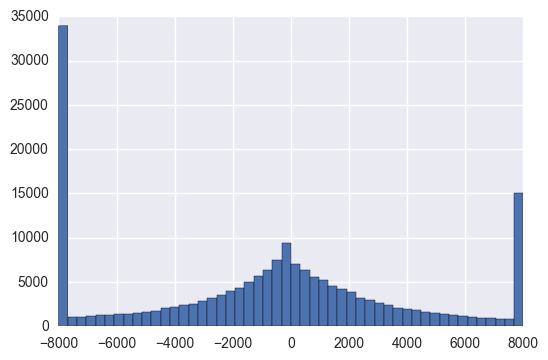

In [6]:
plt.hist(df.cumulative_balance_ml, bins=50)

(array([  8.00000000e+00,   8.00000000e+00,   8.00000000e+00,
          1.20000000e+01,   1.90000000e+01,   1.30000000e+01,
          1.90000000e+01,   1.70000000e+01,   1.50000000e+01,
          1.80000000e+01,   3.10000000e+01,   4.50000000e+01,
          4.80000000e+01,   7.20000000e+01,   1.22000000e+02,
          1.19000000e+02,   1.37000000e+02,   2.25000000e+02,
          3.24000000e+02,   5.24000000e+02,   8.17000000e+02,
          1.30900000e+03,   1.98100000e+03,   3.31400000e+03,
          6.16500000e+03,   1.28700000e+04,   4.86930000e+04,
          9.46670000e+04,   1.14580000e+04,   2.66700000e+03,
          1.11200000e+03,   5.67000000e+02,   4.32000000e+02,
          2.80000000e+02,   1.32000000e+02,   1.03000000e+02,
          7.30000000e+01,   1.01000000e+02,   4.60000000e+01,
          4.10000000e+01,   4.90000000e+01,   2.90000000e+01,
          6.00000000e+00,   1.40000000e+01,   2.10000000e+01,
          1.50000000e+01,   1.70000000e+01,   4.30000000e+01,
        

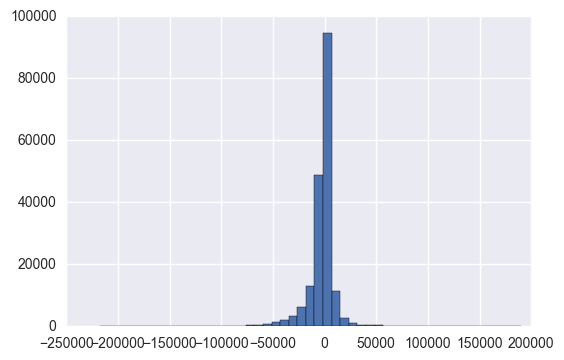

In [7]:
plt.hist(df.cumulative_balance_ml_pretruncate, bins=50)

(array([   67.,    10.,    12.,    13.,    13.,    33.,    18.,    39.,
           47.,    80.,    83.,   150.,   197.,   307.,   351.,   524.,
          734.,   929.,  1264.,  1533.,  1990.,  2490.,  2925.,  3314.,
         4144.,  3765.,  3218.,  2765.,  2426.,  2057.,  1701.,  1531.,
         1175.,  1048.,   867.,   732.,   633.,   580.,   488.,   457.,
          373.,   318.,   260.,   225.,   209.,   176.,   142.,   132.,
          136.,  1003.]),
 array([-8000., -7680., -7360., -7040., -6720., -6400., -6080., -5760.,
        -5440., -5120., -4800., -4480., -4160., -3840., -3520., -3200.,
        -2880., -2560., -2240., -1920., -1600., -1280.,  -960.,  -640.,
         -320.,     0.,   320.,   640.,   960.,  1280.,  1600.,  1920.,
         2240.,  2560.,  2880.,  3200.,  3520.,  3840.,  4160.,  4480.,
         4800.,  5120.,  5440.,  5760.,  6080.,  6400.,  6720.,  7040.,
         7360.,  7680.,  8000.]),
 <a list of 50 Patch objects>)

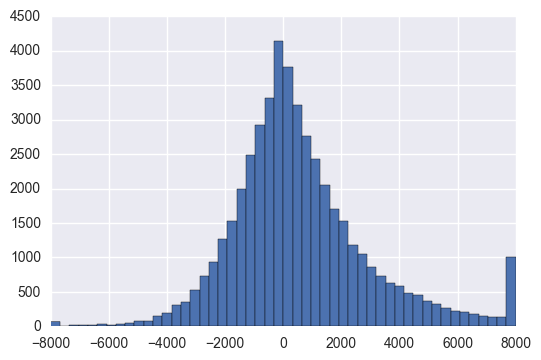

In [8]:
sql = """SELECT *
  FROM mimiciii.fluid_dailybalance
  where day_since_admission = 0"""
df = pd.read_sql_query(sql, conn)
plt.hist(df.daily_balance_ml, bins=50)

In [9]:
sql = """SELECT *
  FROM mimiciii.fluid_balance_day123"""
df = pd.read_sql_query(sql, conn)

In [10]:
df.head()

,row_id,subject_id,icustay_id,hadm_id,day1_input_ml,day1_output_ml,day1_balance_ml,day2_input_ml,day2_output_ml,day2_balance_ml,day3_input_ml,day3_output_ml,day3_balance_ml,balance_truncated
0,1,2,243653,163353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,3,211552,145834,12902.5,497.0,8000.0,2505.0,1200.0,8000.0,810.0,2740.0,7375.0,1
2,3,4,294638,185777,975.0,2150.0,-1175.0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4,5,214757,178980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,5,6,228232,107064,5360.0,1940.0,3420.0,4015.0,1625.0,5810.0,2220.0,2150.0,5880.0,0
